In [20]:
import pandas as pd
import numpy as np

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn import metrics

import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import preprocessing 
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import accuracy_score, confusion_matrix
from matplotlib.pyplot import figure
from sklearn.model_selection import train_test_split


%matplotlib inline

In [3]:

def data_cleaner(df):
    data = df.copy()
    #remove the id, partlybad columns
    data.drop(["id","partlybad"],1,inplace=True)
    #set new index using the date column
    data.set_index(["date"],inplace=True)
    #add binary 'class2' col for event/non-event
    data["class2"] = np.where(data["class4"] == "nonevent", "nonevent","event")
    #arrange to put class2 col at the front
    cols = ['class2'] + [col for col in data if col != 'class2']
    data = data[cols]
    return data

##### New way to generate the data

def data_generator(df):
    '''
    input:
        df: dataframe to split stratified by variable class
        class: string with variable to use as response and as variable to stratify by
    output:
        X_train, y_train: variables and response 60% data 
        X_val, y_val: variables and response 20% data 
        X_trainval, y_trainval: variables and response 80% data (for cross validation)
        X_test, y_test: variables and response 20% data 
    '''
    
    X = df.drop(["class2","class4"], axis=1)
    y = df['class4']
    
    # 60%, 20%, 20%
    # Generate TrainVal 80% and test 20% 
    X_trainval, X_test, y_trainval, y_test = train_test_split( X, y, test_size=0.20, random_state=42, stratify=y)
    
    # Furthermore split train into Train and Val
    X_train, X_val, y_train, y_val= train_test_split( X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval)
    
    return X_train, X_val, X_trainval, X_test, y_train, y_val, y_trainval, y_test

def convert_binary(y):
    '''
    Parameters
    ----------
    y : repsonse variable with 4 classes
    Returns
    -------
    y : reponse variable 2 classes
    '''
    y_bin = np.where(y == "nonevent", "nonevent","event")
    return y_bin

url = "https://raw.githubusercontent.com/williwilliams3/TermProjectIML/master/data/train.csv"
df = pd.read_csv(url)
df = data_cleaner(df)

X_train, X_val, X_trainval, X_test, y_train, y_val, y_trainval, y_test = data_generator(df)

# If needed conversion from 4 classes to binary classes
y_train_bin = convert_binary(y_train)
y_val_bin = convert_binary(y_val)
y_trainval_bin = convert_binary(y_trainval)
y_test_bin = convert_binary(y_test)


In [21]:

lda = LinearDiscriminantAnalysis()
model = lda.fit(X_train, y_train)

print(model.priors_)

[0.22077922 0.07142857 0.21428571 0.49350649]


In [22]:
y_pred_test =model.predict(X_test)
print(np.unique(pred, return_counts=True))


(array(['II', 'Ia', 'Ib', 'nonevent'], dtype='<U8'), array([10,  4, 20, 18]))


              precision    recall  f1-score   support

          II      0.200     0.182     0.190        11
          Ia      0.000     0.000     0.000         4
          Ib      0.300     0.545     0.387        11
    nonevent      0.722     0.500     0.591        26

    accuracy                          0.404        52
   macro avg      0.306     0.307     0.292        52
weighted avg      0.467     0.404     0.418        52

Accuracy on test set:  0.40384615384615385


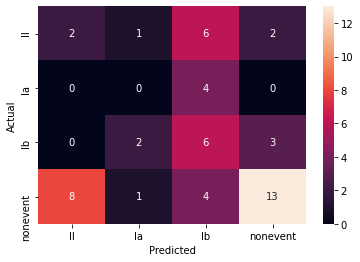

In [23]:
print(classification_report(y_test, pred, digits=3))
confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_pred_test))

In [24]:
qda = QuadraticDiscriminantAnalysis()
model2 = qda.fit(X_train, y_train)
print(model2.priors_)

[0.22077922 0.07142857 0.21428571 0.49350649]


/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:691: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


              precision    recall  f1-score   support

          II      0.200     0.182     0.190        11
          Ia      0.000     0.000     0.000         4
          Ib      0.300     0.545     0.387        11
    nonevent      0.722     0.500     0.591        26

    accuracy                          0.404        52
   macro avg      0.306     0.307     0.292        52
weighted avg      0.467     0.404     0.418        52

Accuracy on test set:  0.4423076923076923


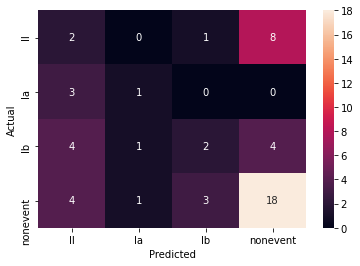

In [25]:
y_pred_test=model2.predict(X_test)

print(classification_report(y_test, pred, digits=3))
confusion_matrix = pd.crosstab(y_test, y_pred_test, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

print('Accuracy on test set: ', metrics.accuracy_score(y_test, y_pred_test))


In [26]:
def select_n_best_feature(X, y, n):
    # Normalize X values to be between 0 and 1
    x = X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    X = pd.DataFrame(x_scaled)

    # Use SelectKBest class to extract top n best features
    bestfeatures = SelectKBest(score_func=chi2, k=n)
    fit = bestfeatures.fit(X,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)

    # Concat two dataframes for better visualization and print best features
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Feature_index','Score']
    #print(featureScores.nlargest(n,'Score'))

    # Filter X. Leave only top n features
    #X = bestfeatures.fit_transform(X, y)
    
    # Return X
    #return X
    return bestfeatures

for  k = 1 0.6346153846153846
for  k = 2 0.6153846153846154
for  k = 3 0.6538461538461539
for  k = 4 0.5384615384615384
for  k = 5 0.5
for  k = 6 0.46153846153846156
for  k = 7 0.5576923076923077
for  k = 8 0.5192307692307693
for  k = 9 0.23076923076923078
for  k = 10 0.07692307692307693
for  k = 11 0.09615384615384616
for  k = 12 0.19230769230769232
for  k = 13 0.21153846153846154
for  k = 14 0.4423076923076923
for  k = 15 0.17307692307692307
for  k = 16 0.057692307692307696
for  k = 17 0.15384615384615385
for  k = 18 0.038461538461538464
for  k = 19 0.36538461538461536
for  k = 20 0.17307692307692307
for  k = 21 0.19230769230769232
for  k = 22 0.25
for  k = 23 0.2692307692307692
for  k = 24 0.23076923076923078
for  k = 25 0.2692307692307692
for  k = 26 0.25
for  k = 27 0.36538461538461536
for  k = 28 0.23076923076923078
for  k = 29 0.38461538461538464
for  k = 30 0.3269230769230769
for  k = 31 0.057692307692307696
for  k = 32 0.1346153846153846
for  k = 33 0.36538461538461536
for  k 

(1.0, 100.0)

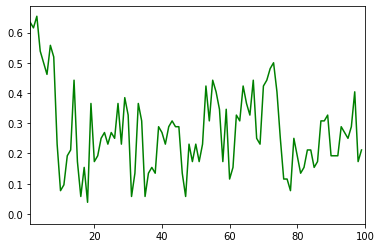

In [31]:
#normalise data

def normalize_0to1(X):
    # Normalize X values to be between 0 and 1
    x = X.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(x_scaled)

X_train_norm = normalize_0to1(X_train)
X_val_norm = normalize_0to1(X_val)
X_test_norm = normalize_0to1(X_test)

acc_rate = np.zeros(100)

for i in range(1,100): 
    bestFeaturesFilter = select_n_best_feature(X_train, y_train, i)
    X_train_filter = bestFeaturesFilter.fit_transform(X_train_norm, y_train)
    X_val_filter = bestFeaturesFilter.fit_transform(X_val_norm, y_val)
    X_test_filter = bestFeaturesFilter.fit_transform(X_test_norm, y_test) 
    
    lda = LinearDiscriminantAnalysis()
    model = lda.fit(X_train_filter, y_train)

    y_pred_val=model.predict(X_val_filter)

#    print('Accuracy on test set: ',metrics.accuracy_score(y_test_bin, y_pred_test))
    acc_rate[i] = metrics.accuracy_score(y_val, y_pred_val)
#    print('Accuracy on train set: ',metrics.accuracy_score(y_train_bin, y_pred_train))
    print('for  k = %i' %i, acc_rate[i])

f, ax = plt.subplots(1)
plt.plot(acc_rate,color="green")
ax.set_xlim(1, 100)

In [33]:
bestFeaturesFilter = select_n_best_feature(X_train, y_train, 3)
X_train_filter = bestFeaturesFilter.fit_transform(X_train_norm, y_train)
X_val_filter = bestFeaturesFilter.fit_transform(X_val_norm, y_val)
X_test_filter = bestFeaturesFilter.fit_transform(X_test_norm, y_test) 

lda = LinearDiscriminantAnalysis()
model = lda.fit(X_train_filter, y_train)

y_pred_test=model.predict(X_test_filter)

#    print('Accuracy on test set: ',metrics.accuracy_score(y_test_bin, y_pred_test))
acc_rate = metrics.accuracy_score(y_test, y_pred_test)
#    print('Accuracy on train set: ',metrics.accuracy_score(y_train_bin, y_pred_train))
print('Accuracy on test with 3 features', acc_rate)

Accuracy on test with 3 features 0.40384615384615385
